In [1]:
import numpy as np 
import pandas as pd 
import os
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
# import os
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from PIL import Image
# import random

# dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
# augmented_dataset_path = "/kaggle/working/augmented_dataset"  
# possible_augmentations = [
#     transforms.RandomHorizontalFlip(p=1.0),  
#     transforms.RandomRotation(degrees=30),  
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  
#     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  
#     transforms.RandomPerspective(distortion_scale=0.4, p=1.0),  
#     transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0)),  
# ]

# original_dataset = ImageFolder(root=dataset_path)
# if not os.path.exists(augmented_dataset_path):
#     os.makedirs(augmented_dataset_path)

# for class_name in original_dataset.classes:
#     os.makedirs(os.path.join(augmented_dataset_path, class_name), exist_ok=True)

# num_augmentations = 8  
# for img_path, label in original_dataset.samples:
#     img = Image.open(img_path).convert("RGB")
#     class_name = original_dataset.classes[label]
#     save_dir = os.path.join(augmented_dataset_path, class_name)

#     img.save(os.path.join(save_dir, os.path.basename(img_path)))
#     for i in range(num_augmentations):
#         selected_augmentations = random.sample(possible_augmentations, k=random.randint(1, 3)) 
#         transform_pipeline = transforms.Compose([transforms.Resize((227, 227))] + selected_augmentations)  
        
#         augmented_img = transform_pipeline(img)
#         save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(img_path)}")
#         augmented_img.save(save_path)

# print(f"Dataset is completely augmented ")

In [3]:
# import shutil
# import os

# def zip_folder(folder_path, output_zip_path):
#     if not os.path.exists(folder_path):
#         print(f"Error: The folder '{folder_path}' does not exist.")
#         return
#     shutil.make_archive(output_zip_path, 'zip', folder_path)
#     print(f"Folder '{folder_path}' has been zipped to '{output_zip_path}.zip'")

# zip_folder("/kaggle/working/augmented_dataset", "/kaggle/working/augmented_dataset_zip_file")
# print(f"successfully zipped")

In [4]:
augmented_dataset_path = "/kaggle/input/thermal-dataset"

In [5]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_dataset = ImageFolder(root=augmented_dataset_path, transform=transform)
train_size = int(0.6 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()  

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

num_epochs = 70
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "resnet_trained.pth")
print("\nModel saved as resnet_trained.pth")


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]
<ipython-input-6-a8d0d81e4259>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-6-a8d0d81e4259>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/70, Loss: 1.5995, Accuracy: 35.09%
Epoch 2/70, Loss: 1.4836, Accuracy: 41.64%
Epoch 3/70, Loss: 1.4030, Accuracy: 45.72%
Epoch 4/70, Loss: 1.3372, Accuracy: 47.99%
Epoch 5/70, Loss: 1.2791, Accuracy: 51.81%
Epoch 6/70, Loss: 1.2305, Accuracy: 54.57%
Epoch 7/70, Loss: 1.1858, Accuracy: 56.52%
Epoch 8/70, Loss: 1.1563, Accuracy: 57.37%
Epoch 9/70, Loss: 1.1218, Accuracy: 60.05%
Epoch 10/70, Loss: 1.0908, Accuracy: 61.97%
Epoch 11/70, Loss: 1.0715, Accuracy: 61.71%
Epoch 12/70, Loss: 1.0448, Accuracy: 62.75%
Epoch 13/70, Loss: 1.0255, Accuracy: 64.39%
Epoch 14/70, Loss: 1.0230, Accuracy: 63.72%
Epoch 15/70, Loss: 0.9926, Accuracy: 65.49%
Epoch 16/70, Loss: 0.9791, Accuracy: 66.51%
Epoch 17/70, Loss: 0.9643, Accuracy: 66.39%
Epoch 18/70, Loss: 0.9410, Accuracy: 68.00%
Epoch 19/70, Loss: 0.9411, Accuracy: 67.24%
Epoch 20/70, Loss: 0.9246, Accuracy: 68.00%
Epoch 21/70, Loss: 0.9123, Accuracy: 69.13%
Epoch 22/70, Loss: 0.8949, Accuracy: 69.63%
Epoch 23/70, Loss: 0.8906, Accuracy: 69.8

In [7]:
import numpy as np
import torch

class_names = augmented_dataset.classes  
num_classes = len(class_names)  

def calculate_per_class_accuracy(model, data_loaders, device, datasets=["Training", "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes) 
        class_total = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        print(f"\n Final Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):  
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"{class_names[i]}: {dataset_type} = {accuracy:.2f}%")
            else:
                print(f"{class_names[i]}: {dataset_type} = No samples available ")

data_loaders = [train_loader, val_loader, test_loader]
datasets = ["Training", "Validation", "Test"]
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)


 Final Per-Class Training Accuracy:

BLB: Training = 84.09%
Blast: Training = 60.39%
healthy: Training = 74.85%
hispa: Training = 81.95%
leaf folder: Training = 85.64%
leaf spot: Training = 77.31%

 Final Per-Class Validation Accuracy:

BLB: Validation = 80.84%
Blast: Validation = 40.91%
healthy: Validation = 74.72%
hispa: Validation = 78.80%
leaf folder: Validation = 79.63%
leaf spot: Validation = 64.83%

 Final Per-Class Test Accuracy:

BLB: Test = 78.77%
Blast: Test = 43.18%
healthy: Test = 77.78%
hispa: Test = 78.54%
leaf folder: Test = 78.87%
leaf spot: Test = 69.23%


Test Accuracy: 73.30%


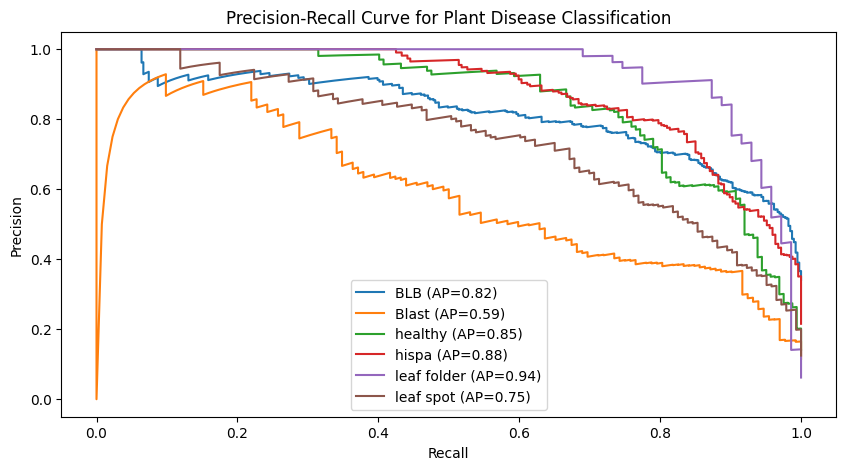

In [8]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
y_true = []
y_scores = []
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

plt.figure(figsize=(10, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Plant Disease Classification")
plt.legend()
plt.show()

In [9]:
""" 

UNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,
ViT, EfficientNetv2
"""

' \n\nUNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,\nViT, EfficientNetv2\n'

In [10]:
# alexnet , resnet , googlenet , unet , vgg
# segnet , inception , rcnn , vit  , efficient net